In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black')

import lagrangian_optim as lgopt
from scipy import optimize as sp_optimize

from mrashpen.models.normal_means_ash_scaled import NormalMeansASHScaled
from mrashpen.models.plr_ash                 import PenalizedMrASH
from mrashpen.inference.penalized_regression import PenalizedRegression as PLR

### Generate data from Normal Means model

Sample $\mathbf{b}$ from a mixture of Gaussians, and sample $\mathbf{y}$ from the multivariate Gaussian $N_n(\mathbf{b}, \mathbb{I}_n)$, where $\mathbb{I}_n$ is the $n \times n$ identity matrix.

$\mathbf{b} \sim \sum_{k = 1}^{K}w_k N(0, \sigma_k^2)$

$\mathbf{y} \sim N_n(\mathbf{b}, \mathbb{I}_n)$,

where $n$ is the number of samples.
The posterior probability $\hat{q}(\mathbf{b} \mid \mathbf{y}, w_1, \ldots, w_K, \sigma_1, \ldots, \sigma_K)$ is obtained analytically (using Eq. 26 and 27 of [this document](https://www.overleaf.com/project/60d0d9301e098e4dbe8e3521)).
We also calculate the posterior mean $\mathbf{b}^{*} \triangleq \mathbb{E}_{\hat{q}}[\mathbf{b}]$.

In [2]:
def sample_mixgauss(wk, sk, size):
    runif = np.random.uniform(0, 1, size = size)
    gcomp = np.digitize(runif, np.cumsum(wk))
    x = np.zeros(size)
    for i, gc in enumerate(gcomp):
        if sk[gc] > 0:
            x[i] = np.random.normal(0, sk[gc]) 
    return x

def NM_sample(mean, std = 1.0):
    p   = mean.shape[0]
    cov = np.eye(p) * std * std
    y   = np.random.multivariate_normal(mean, cov)
    return y

def initialize_ash_prior(k, scale = 2, sparsity = None):
    w = np.zeros(k)
    w[0] = 1 / k if sparsity is None else sparsity
    w[1:(k-1)] = np.repeat((1 - w[0])/(k-1), (k - 2))
    w[k-1] = 1 - np.sum(w)
    sk2 = np.square((np.power(scale, np.arange(k) / k) - 1))
    prior_grid = np.sqrt(sk2)
    return w, prior_grid

In [3]:
p = 500
k = 4
sparsity = 0.8
strue = 1.0

np.random.seed(100)
wtrue, sk = initialize_ash_prior(k, sparsity = sparsity, scale = 10.0)
#sk = np.logspace(-1, k-2, k)
btrue = sample_mixgauss(wtrue, sk, p)
y = NM_sample(btrue, std = strue)
print ("Standard deviation of prior mixture components: "
       + ', '.join([f"{x:.3f}" for x in sk])
      )

dj = np.ones(p)
nmash = NormalMeansASHScaled(y, strue, wtrue, sk, d = dj)
qphi, qmu, qvar = nmash.posterior()

bpostmean = np.sum(qphi * qmu, axis = 1)
wpost = np.sum(qphi, axis = 0)
wpost = wpost / np.sum(wpost)

Standard deviation of prior mixture components: 0.000, 0.778, 2.162, 4.623
2022-03-29 14:47:51,798 | mrashpen.models.normal_means_ash_scaled | DEBUG | Calculating posterior for NM model.


In [4]:
## btrue = np.load('../trendfiltering_examples/target_b.npy')

In [5]:
bconst = bpostmean.copy()

Minv = lgopt.shrinkage_operator_inverse(bconst, strue, wpost, sk, dj)
theta_newraph = Minv.x
b_newraph = lgopt.shrink_theta(theta_newraph, strue, wpost, sk, dj)

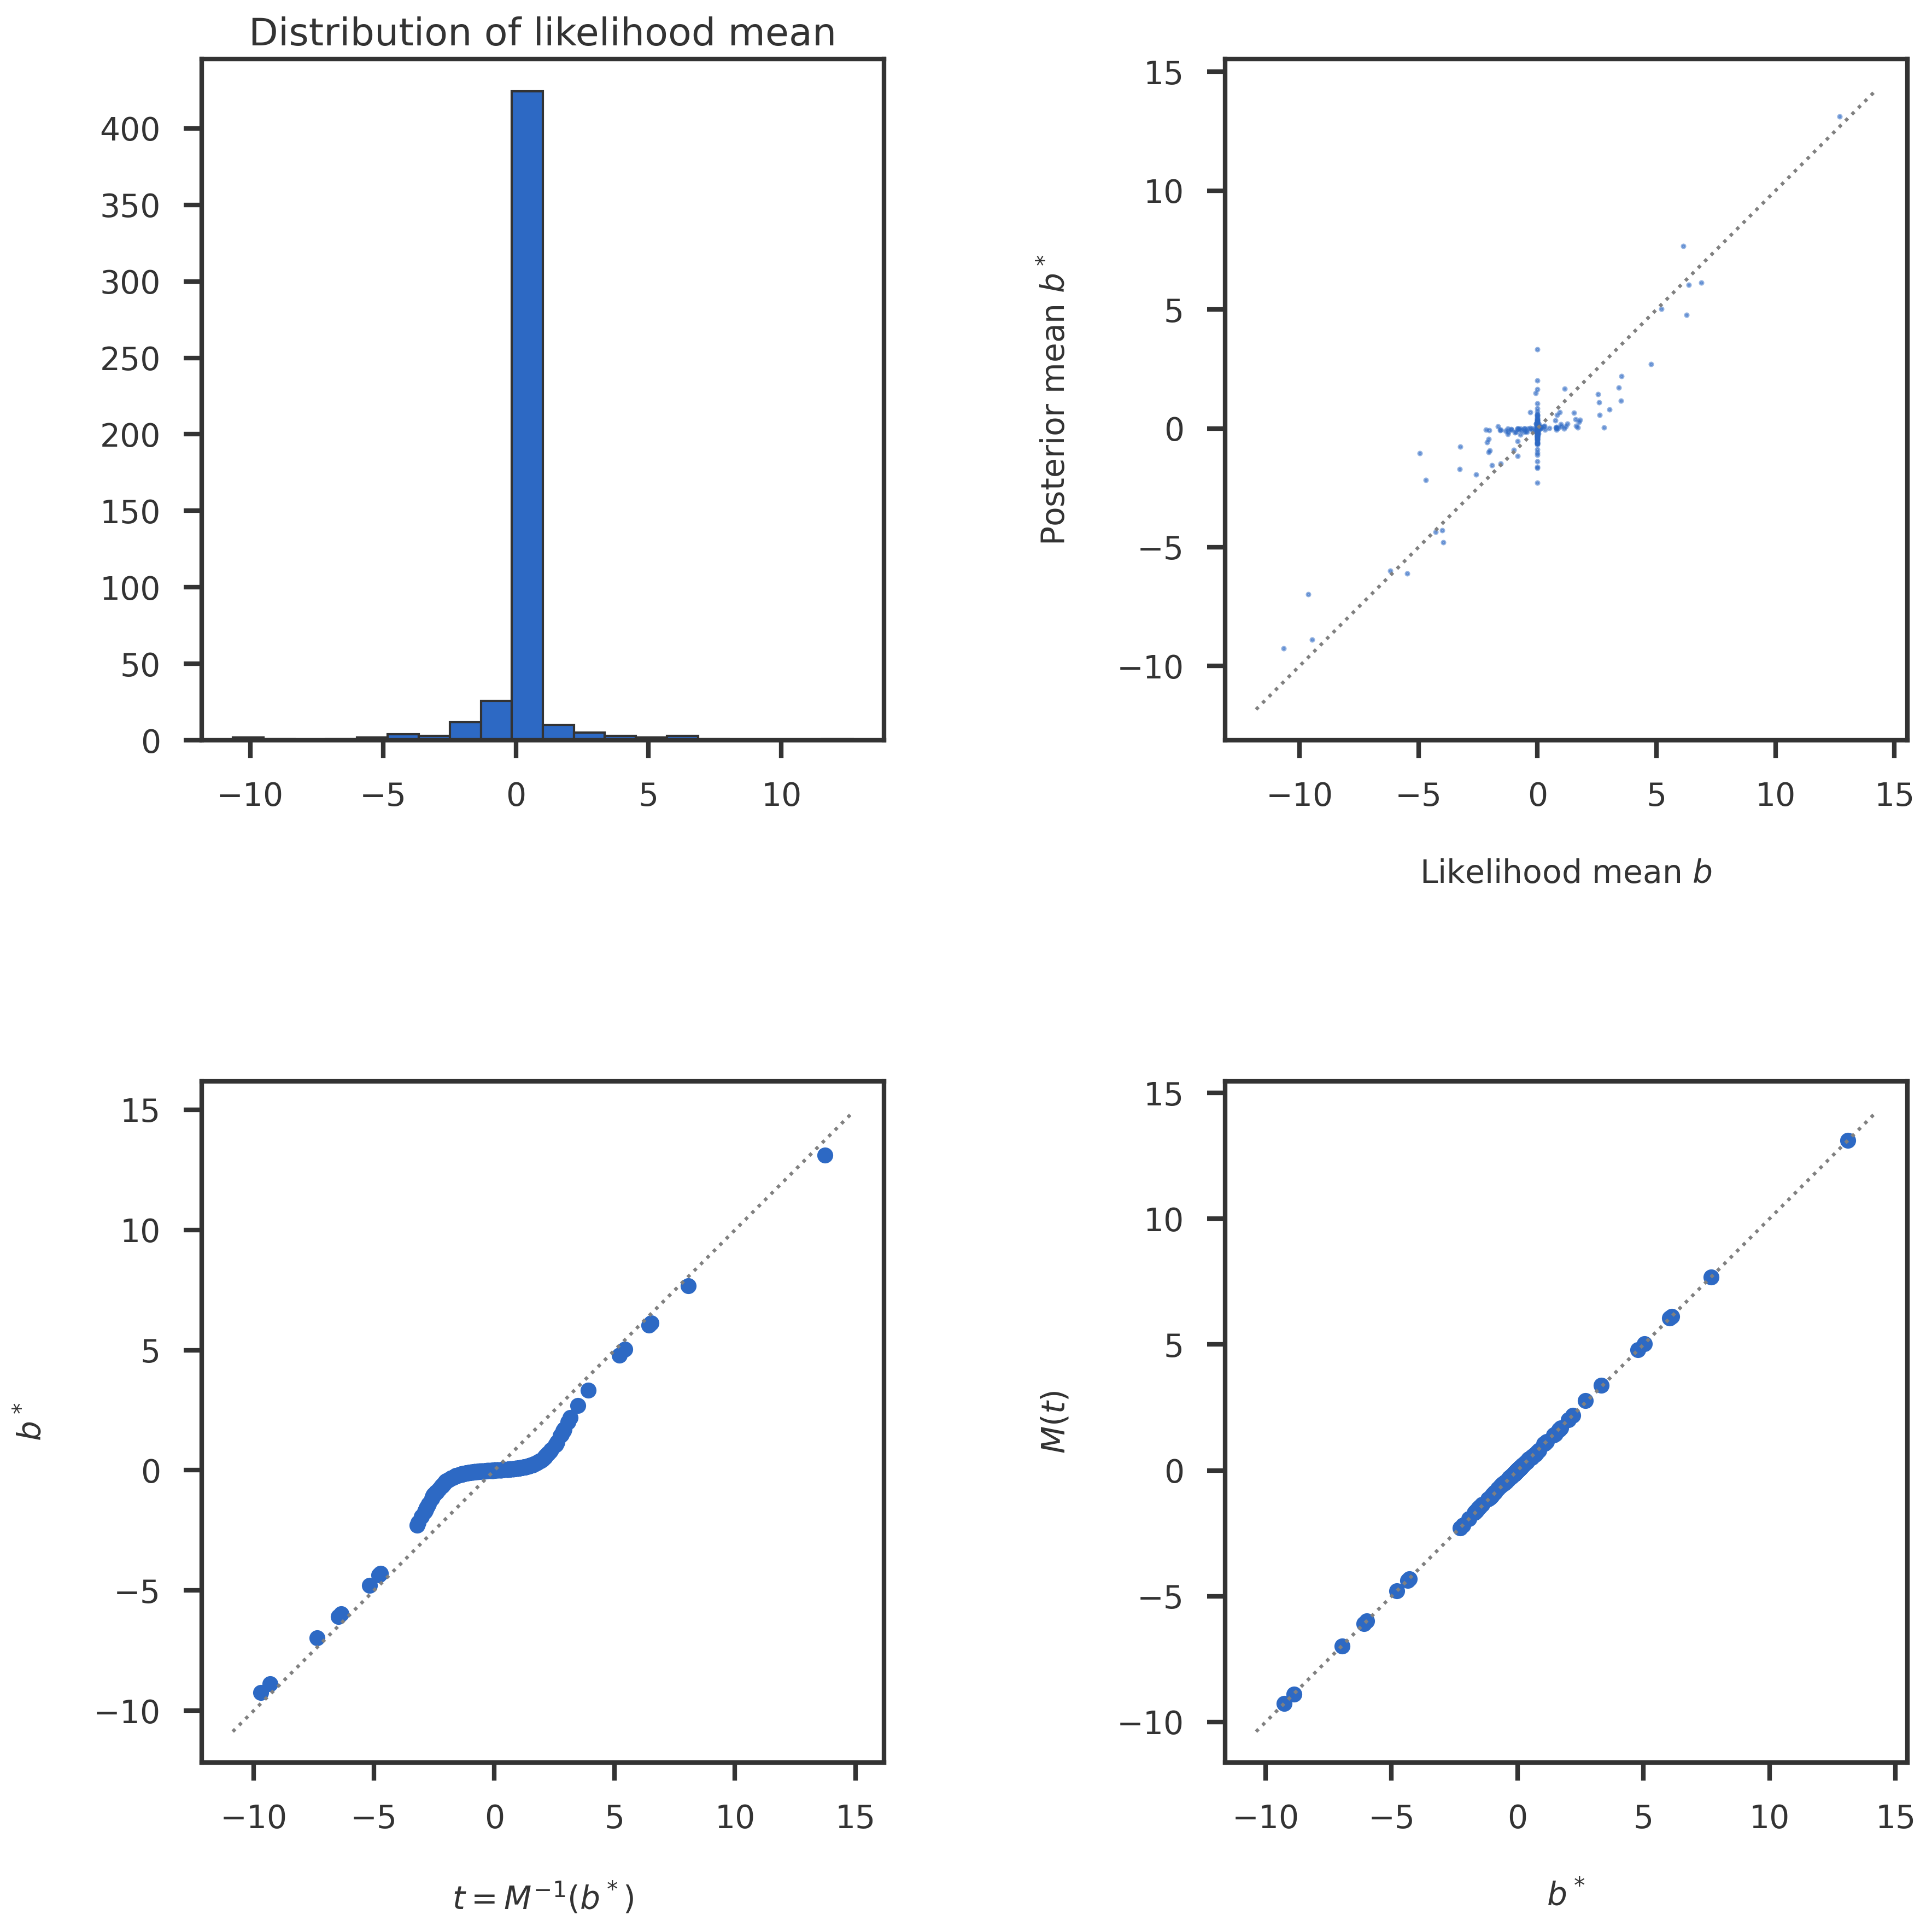

In [6]:
fig = plt.figure(figsize = (12, 12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
ax1.hist(btrue)
ax1.set_title("Distribution of likelihood mean")

ax2.scatter(btrue, bpostmean, s=2, alpha = 0.5)
mpl_utils.plot_diag(ax2)
ax2.set_xlabel(r"Likelihood mean $b$")
ax2.set_ylabel(r"Posterior mean $b^*$")
#ax1.hist(mean)

#ax3.scatter(bconst, theta_newraph)
ax3.scatter(theta_newraph, bconst)
mpl_utils.plot_diag(ax3)
ax3.set_ylabel(r"$b^*$")
ax3.set_xlabel(r"$t = M^{-1}(b^*)$")

ax4.scatter(bconst, b_newraph)
mpl_utils.plot_diag(ax4)
ax4.set_xlabel(r"$b^*$")
#ax4.set_ylabel(r"$M(M^{-1}(b^*))$")
ax4.set_ylabel(r"$M(t)$")

plt.tight_layout()
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
plt.show()

### Check derivatives of ρ(b)

In [7]:
def penalty_func(b, ak, std, sk, dj, 
                 jac = True, 
                 softmax_base = np.exp(1),
                 method = 'fssi-cubic',
                 ngrid = 1000
                ):
    wk = lgopt.softmax(ak, base = softmax_base)
    k = ak.shape[0]
    p = b.shape[0]
    Minv = lgopt.shrinkage_operator_inverse(b, std, wk, sk, dj, method = method, ngrid = ngrid)
    t = Minv.x
    nm = NormalMeansASHScaled(t, std, wk, sk, d = dj)
    s2 = nm.yvar
    #rhoMtj = - nm.logML #- 0.5 * nm.yvar * np.square(nm.logML_deriv)
    rhoMtj = - nm.logML - 0.5 * np.square(t - b) / nm.yvar
    rhoMt = np.sum(rhoMtj)
    if jac:
        dHdb = (t - b) / nm.yvar
        # dMdw = nm.yvar.reshape(-1, 1) * nm.logML_deriv_wderiv
        # dMdtinv = 1 / (1 + nm.yvar * nm.logML_deriv2)
        # dtdw = - nm.logML_deriv_wderiv * (nm.yvar * dMdtinv).reshape(-1, 1)
        ## Derivative of -0.5(t-b)^2 / s2
        # dHdw = - ((t - b) / nm.yvar).reshape(-1, 1) * dtdw
        ## Derivative of -logML(t)
        # dHdw = - nm.logML_wderiv - (nm.logML_deriv).reshape(-1, 1) * dtdw
        dHdw = - nm.logML_wderiv
        dHdw = np.sum(dHdw, axis = 0)
        akjac = np.log(softmax_base) * wk.reshape(-1, 1) * (np.eye(k) - wk)
        dHda = np.sum(dHdw * akjac, axis = 1)
        return rhoMt, dHdb, dHda
    else:
        return rhoMt
    

apost = np.log(wpost)
bval = np.random.rand(p)
#bval = bconst.copy()
obj, dHdb, dHda = penalty_func(bval, apost, strue, sk, dj)

print("Objective", obj)

print("Derivative with respect to ak")
eps = 1e-8
dHda_numeric = np.zeros(k)
for indx in range(k):
    ak_eps = apost.copy()
    ak_eps[indx] += eps
    obj_eps = penalty_func(bval, ak_eps, strue, sk, dj, jac = False)
    dHda_numeric[indx] = (obj_eps - obj) / eps
print(dHda_numeric)    
print(dHda)
print()

indxlim = 10
print("Derivative with respect to b_j")
dHdb_numeric = np.zeros(p)
for indx in range(indxlim):
    b_eps = bval.copy()
    b_eps[indx] += eps
    obj_eps = penalty_func(b_eps, apost, strue, sk, dj, jac = False)
    dHdb_numeric[indx] = (obj_eps - obj) / eps
print(dHdb_numeric[:indxlim])
print(dHdb[:indxlim])

Objective 811.4267792432063
Derivative with respect to ak
[ 54.14638053 -12.95846914 -31.06736131 -10.12052735]
[ 54.14637431 -12.95846605 -31.06737487 -10.12053339]

Derivative with respect to b_j
[1.57023123 1.55803264 1.06650759 0.79934352 1.58079274 1.57698423
 1.05135314 1.38948053 1.56513806 1.54152531]
[1.57023065 1.55803809 1.06650754 0.7993409  1.58078756 1.57697798
 1.05135553 1.38947746 1.56513571 1.54151753]


#### Derivative of M^{-1}(b)

In [8]:
def myfunc_Minverse(b, ak, std, sk, dj, jac = True, softmax_base = np.exp(1)):
    wk = lgopt.softmax(ak, base = softmax_base)
    k = ak.shape[0]
    p = b.shape[0]
    Minv = lgopt.shrinkage_operator_inverse(b, std, wk, sk, dj, method = 'fssi-cubic', ngrid = 500)
    t = Minv.x
    tsum = np.sum(t)
    if jac:
        nm = NormalMeansASHScaled(t, std, wk, sk, d = dj)
        #dMdw = nm.yvar.reshape(-1, 1) * nm.logML_deriv_wderiv
        dMdtinv = 1 / (1 + nm.yvar * nm.logML_deriv2)
        dtdw = - nm.logML_deriv_wderiv * (nm.yvar * dMdtinv).reshape(-1, 1)
        dtdw = np.sum(dtdw, axis = 0)
        akjac = np.log(softmax_base) * wk.reshape(-1, 1) * (np.eye(k) - wk)
        dtda = np.sum(dtdw * akjac, axis = 1)
        return tsum, dtda
    else:
        return tsum
    
Minvb, dtda = myfunc_Minverse(bconst, apost, strue, sk, dj)

eps = 1e-8
dtda_numeric = np.zeros(k)
for indx in range(k):
    ak_eps = apost.copy()
    ak_eps[indx] += eps
    Minvb_eps = myfunc_Minverse(bconst, ak_eps, strue, sk, dj, jac = False)
    dtda_numeric[indx] = (Minvb_eps - Minvb) / eps
    print(Minvb_eps)
print(dtda_numeric)    
print(dtda)

-34.1541305007457
-34.15413041123544
-34.154130387764226
-34.154130396083225
[-7.67885453  1.27217135  3.61929295  2.78739307]
[-7.67877691  1.27215804  3.61925549  2.78736338]


Hybr: -34.154128806490725
FSSI: -34.153430041189424
FSSI-Cubic: -34.15412898448387


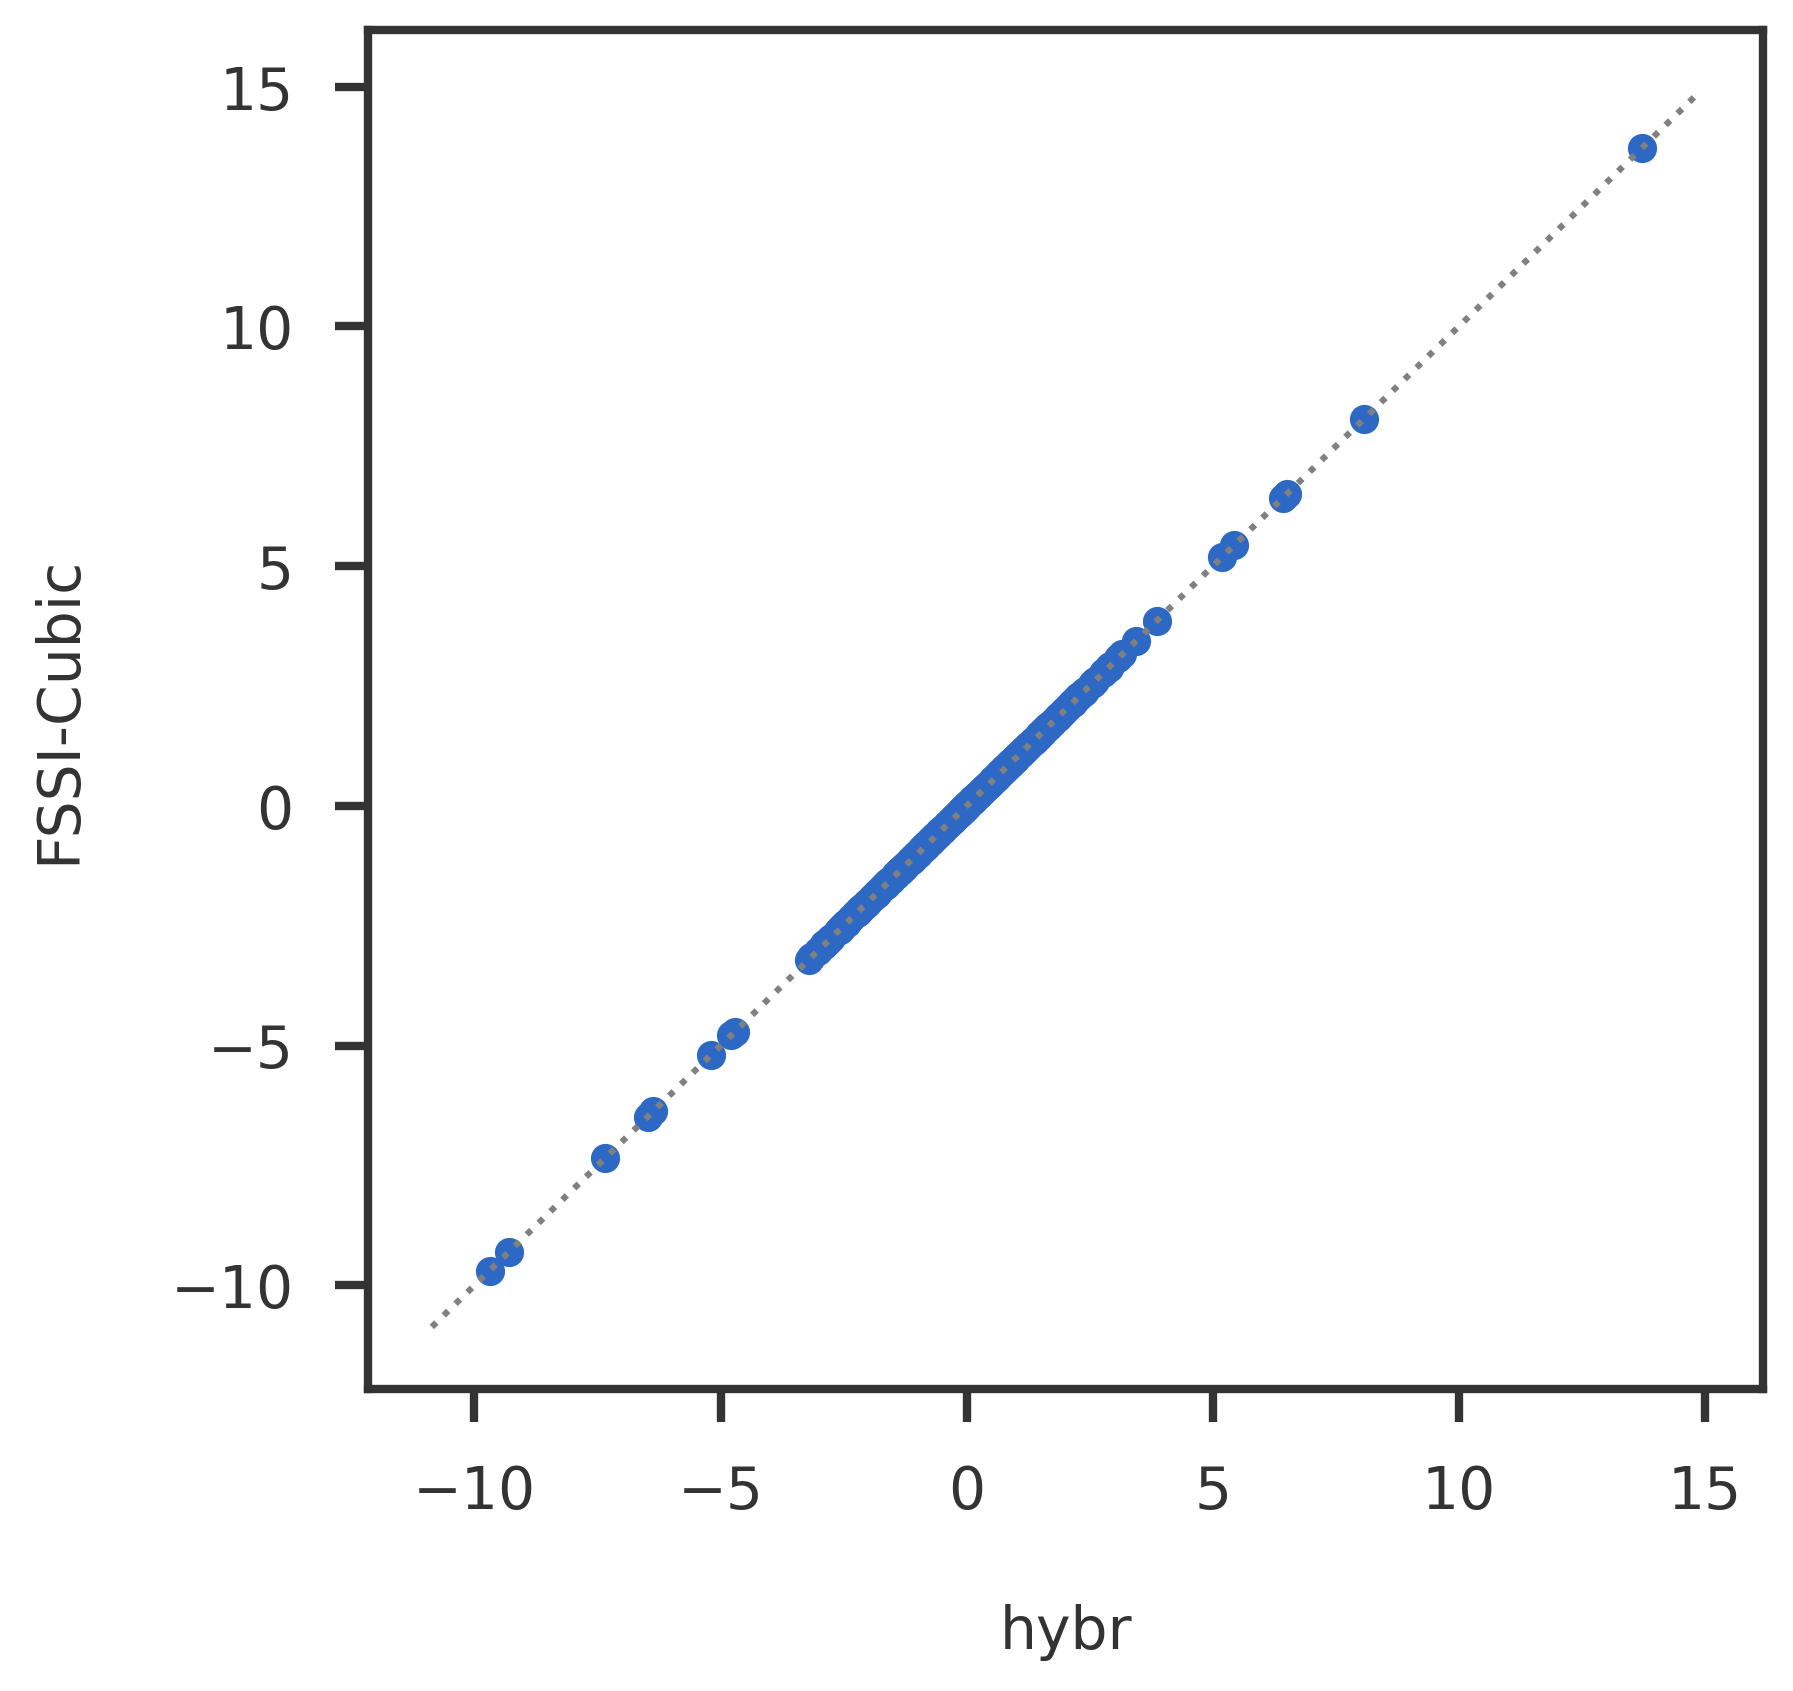

In [14]:
t_hybr = lgopt.shrinkage_operator_inverse(bconst, strue, wpost, sk, dj, method = 'hybr').x
t_fssi = lgopt.shrinkage_operator_inverse(bconst, strue, wpost, sk, dj, method = 'fssi-linear', ngrid = 1000).x
t_fssi3 = lgopt.shrinkage_operator_inverse(bconst, strue, wpost, sk, dj, method = 'fssi-cubic', ngrid = 1000).x
print("Hybr:", np.sum(t_hybr))
print("FSSI:", np.sum(t_fssi))
print("FSSI-Cubic:", np.sum(t_fssi3))

fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
ax1.scatter(t_hybr, t_fssi3)
mpl_utils.plot_diag(ax1)
ax1.set_xlabel ("hybr")
ax1.set_ylabel ("FSSI-Cubic")
plt.show()

### Obtain posterior w given posterior mean b

In [10]:
def obj_func(ak, bj, std, sk, dj):
    rhob, dHdb, dHda = penalty_func(bj, ak, std, sk, dj, 
                                    jac = True, 
                                    softmax_base = np.exp(1), 
                                    method = 'fssi-cubic',
                                    ngrid = 1000)
    return rhob, dHda


winit, _ = initialize_ash_prior(k)
print ("Initial values: " + ', '.join([f"{x:.3f}" for x in winit]))
opt_min = sp_optimize.minimize(obj_func, winit,
                               args = (bconst, strue, sk, dj),
                               method = 'l-bfgs-b', jac = True,
                               #options = {'disp': True, 'maxiter': 10, 'return_all': True}
                               options = {'disp':True, 'maxiter': 50}
                              )
what = lgopt.softmax(opt_min.x)

Initial values: 0.250, 0.250, 0.250, 0.250
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.98908D+02    |proj g|=  6.23980D+01

At iterate    1    f=  7.24950D+02    |proj g|=  4.08243D+01

At iterate    2    f=  6.94042D+02    |proj g|=  7.78780D+00

At iterate    3    f=  6.92833D+02    |proj g|=  2.39215D+00

At iterate    4    f=  6.92657D+02    |proj g|=  1.94551D+00

At iterate    5    f=  6.92144D+02    |proj g|=  1.70515D+00

At iterate    6    f=  6.92087D+02    |proj g|=  3.25226D-01

At iterate    7    f=  6.92084D+02    |proj g|=  2.33108D-02

At iterate    8    f=  6.92084D+02    |proj g|=  1.78972D-02

At iterate    9    f=  6.92083D+02    |proj g|=  1.58117D-02

At iterate   10    f=  6.92083D+02    |proj g|=  1.24129D-02

At iterate   11    f=  6.92083D+02    |proj g|=  4.93522D-03


 This problem is unconstrained.



At iterate   12    f=  6.92083D+02    |proj g|=  4.38801D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     13      1     0     0   4.388D-04   6.921D+02
  F =   692.08324247807366     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [11]:
print ("Posterior values: " + ', '.join([f"{x:.3f}" for x in wpost]))
print ("Estimated values: " + ', '.join([f"{x:.3f}" for x in what]))

Posterior values: 0.798, 0.068, 0.068, 0.066
Estimated values: 0.744, 0.141, 0.048, 0.066


### Time required

In [12]:
%%timeit -n 5 -r 7

Minv = lgopt.shrinkage_operator_inverse(bconst, strue, wpost, sk, dj, method = 'fssi-linear', ngrid = 1000)
t_fssi = Minv.x

2.45 ms ± 162 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [13]:
%%timeit -n 5 -r 7

Minv = lgopt.shrinkage_operator_inverse(bconst, strue, wpost, sk, dj, method = 'fssi-cubic', ngrid = 1000)
t_fssi3 = Minv.x

2.67 ms ± 370 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)
